<a href="https://colab.research.google.com/github/loposkin/competition/blob/main/competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


# Data Preparation

First, we read the data from csv

In [2]:
df = pd.read_csv('races.csv', sep=';', index_col='id')

In [3]:
df.head()

,race_created,race_driven,track_id,challenger,opponent,money,fuel_consumption,winner,status,forecast,weather
id,,,,,,,,,,,
1,06.03.2012,06.03.2012 00:00,12,5,2,30,0.63,5,finished,"a:4:{s:5:""sunny"";i:10;s:5:""rainy"";i:70;s:8:""th...",rainy
2,06.03.2012,06.03.2012 00:03,12,5,4,30,0.63,4,finished,"a:4:{s:5:""sunny"";i:70;s:5:""rainy"";i:15;s:8:""th...",sunny
3,06.03.2012,0000-00-00 00:00:00,3,10,5,30,0.63,0,declined,"a:4:{s:5:""sunny"";i:70;s:5:""rainy"";i:10;s:8:""th...",NaN
4,06.03.2012,06.03.2012 00:06,12,5,4,30,0.63,5,finished,"a:4:{s:5:""sunny"";i:25;s:5:""rainy"";i:75;s:8:""th...",sunny
5,06.03.2012,0000-00-00 00:00:00,12,4,5,30,0.63,0,declined,"a:4:{s:5:""sunny"";i:45;s:5:""rainy"";i:20;s:8:""th...",NaN


We will parse the `forecast` column into 4 different columns

In [4]:
forecast_types = ['sunny', 'rainy', 'thundery', 'snowy']
stripped = df['forecast'].str.lstrip('a:4:').str.strip("{}")

splitted = stripped.str.split(';')


for count, forecast_type in enumerate(forecast_types):
    df[forecast_type] = splitted.str[2 * count + 1].str.partition(':')[2].astype(int)




In [5]:
['id', 'race_created', 'race_driven', 'track_id', 
 'challenger', 'opponent', 'money', 'fuel_consumption', 
 'winner', 'status', 'sunny', 'rainy',
 'thundery', 'snowy', 'weather']
df = df.drop('forecast', axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166609 entries, 1 to 166609
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   race_created      166609 non-null  object
 1   race_driven       166609 non-null  object
 2   track_id          166609 non-null  int64 
 3   challenger        166609 non-null  int64 
 4   opponent          166609 non-null  int64 
 5   money             166609 non-null  int64 
 6   fuel_consumption  166609 non-null  object
 7   winner            166609 non-null  int64 
 8   status            166609 non-null  object
 9   weather           109099 non-null  object
 10  sunny             166609 non-null  int64 
 11  rainy             166609 non-null  int64 
 12  thundery          166609 non-null  int64 
 13  snowy             166609 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 19.1+ MB


As we can see the column fuel consumption has an `object` dtype. Let's look at the values closer

In [7]:
df.sample(5, random_state=42)

,race_created,race_driven,track_id,challenger,opponent,money,fuel_consumption,winner,status,weather,sunny,rainy,thundery,snowy
id,,,,,,,,,,,,,,
41017,06.07.2012,0000-00-00 00:00:00,12,46,0,100,02. Jul,0,retired,NaN,40,50,5,5
98837,26.12.2012,28.12.2012 14:07,5,4506,81,30,2.529,4506,finished,sunny,80,0,20,0
107300,28.01.2013,0000-00-00 00:00:00,12,7844,7937,30,02. Jan,0,retired,NaN,100,0,0,0
26343,19.05.2012,0000-00-00 00:00:00,5,2237,0,50,2.664,0,retired,NaN,40,10,25,25
86021,30.11.2012,30.11.2012 12:26,12,130,4506,30,3.075,4506,finished,sunny,70,25,0,5


Looks like the csv was imported in Excel and got the wrong datatype assigned. Let's check it.

In [8]:
month_abbr = ['Jan', 'Feb', 'Mrz', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']
month_number = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

fuel_consumption = df['fuel_consumption']

fuel_consumption[~fuel_consumption.str.replace('\.', '').str.isnumeric()]

id
292       Jan 17
295       Jan 17
296       Jan 17
297       Jan 17
305       Jan 17
           ...  
166578    Jun 63
166580    Jan 52
166592    Jun 84
166593    Jun 84
166594    Jun 18
Name: fuel_consumption, Length: 58753, dtype: object

We replace the months names with corresponding numbers

In [9]:
for counter, month in enumerate(month_abbr):
  fuel_consumption = fuel_consumption.str.replace(month, month_number[counter])

fuel_consumption = fuel_consumption.str.replace(' ', '')

In [10]:
fuel_consumption[~fuel_consumption.str.replace('\.', '').str.isnumeric()]

Series([], Name: fuel_consumption, dtype: object)

Now all values are numeric

In [11]:
df['fuel_consumption'] = pd.to_numeric(fuel_consumption)

In [12]:
df['fuel_consumption'].dtype

dtype('float64')

Now, let's look at dates

In [13]:
df['race_created'] = pd.to_datetime(df['race_created'])

The dates for cancelled races(`0000-00-00`) cannot be parsed. We insert NaT instead of these values.

In [14]:
pd.to_datetime(df['race_driven'], errors='coerce')

id
1        2012-06-03 00:00:00
2        2012-06-03 00:03:00
3                        NaT
4        2012-06-03 00:06:00
5                        NaT
                 ...        
166605   2017-06-14 01:55:00
166606   2017-06-26 20:54:00
166607                   NaT
166608   2017-06-24 21:22:00
166609                   NaT
Name: race_driven, Length: 166609, dtype: datetime64[ns]

# Data Exploration

Let's look at the histograms of our features.

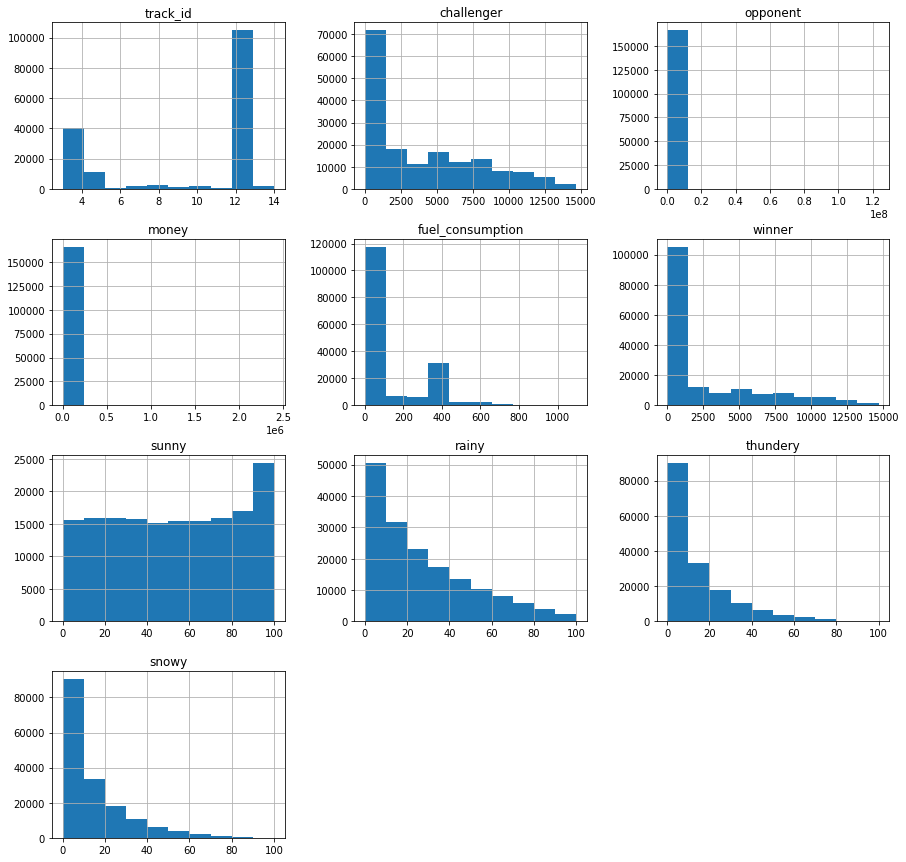

In [15]:
df.hist(figsize=(15, 15))
None

From this histograms, we cannot really say something interesting. 

-
- the track 12 is popular :)

Let's now look at the `status` column

In [16]:
df['status'].value_counts()

finished    109099
retired      43224
declined     11392
waiting       2894
Name: status, dtype: int64

In [17]:
finished = df[df['status'] == 'finished']

We'll create a new feature which indicates whether the `challenger` won the race. We drop the `winner` column

In [18]:
finished['challengerWon'] = False
finished.loc[finished['challenger'] == finished['winner'], 'challengerWon'] = True
# finished = finished.drop('winner', axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


**Question 1:** How often the challenger wins?

In [19]:
finished['challengerWon'].sum() / finished.shape[0]

0.5607659098616853

Looks like the challengers win the games a bit more often.

**Question 2:** How often the weather forecast is true?

In [20]:
predictions = finished[['sunny', 'rainy', 'thundery', 'snowy']].idxmax(axis=1)
(predictions == finished['weather']).sum() / finished.shape[0]


0.6535348628310067

So, the weather is predicted with an accuracy of approx. 0.653. That's pretty good. 

**Question 3:** On which tracks the fuel consumption is the highest?

In [21]:
finished.groupby('track_id')['fuel_consumption'].mean()

track_id
3      77.514691
4     184.521373
5      15.510455
6      61.548289
7     197.583233
8     153.857413
9     117.047032
10    130.129777
11     45.633941
12    129.704447
13     55.213707
14     68.704480
Name: fuel_consumption, dtype: float64

As we can see the tracks 1 and 2 are not used, we'll discover it later.

In [22]:
finished.groupby('track_id')['fuel_consumption'].mean().nlargest()

track_id
7     197.583233
4     184.521373
8     153.857413
10    130.129777
12    129.704447
Name: fuel_consumption, dtype: float64

**Question 4:** On which tracks the challenger wins more often

In [23]:
finished.groupby('track_id')['challengerWon'].sum() / finished.groupby('track_id')['challengerWon'].count()

track_id
3     0.488460
4     0.541176
5     0.657692
6     0.488073
7     0.546308
8     0.674699
9     0.718028
10    0.567276
11    0.563147
12    0.572163
13    0.535052
14    0.543933
Name: challengerWon, dtype: float64

The highest win rate for the challenger is on the track 9. There are no tracks with `track_id` 1 and 2.

Let's find how many races took place each year/month.

In [24]:
finished['race_created'] = pd.to_datetime(finished['race_created'])
finished['race_driven'] = pd.to_datetime(finished['race_driven'])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
years = finished[['race_created', 'race_driven']]
years['race_driven'] = years['race_driven'].dt.year
years['race_created'] = years['race_created'].dt.year

months = finished[['race_created', 'race_driven']]
months['race_driven'] = months['race_driven'].dt.month
months['race_created'] = months['race_created'].dt.month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3c99efb10>]],
      dtype=object)

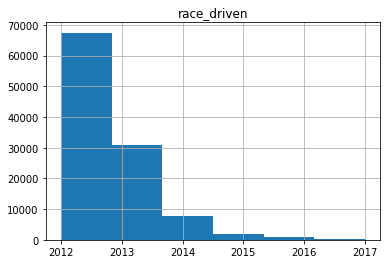

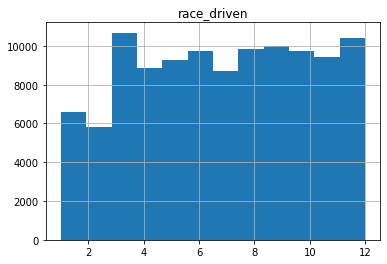

In [26]:

years.hist(column=['race_driven'], bins=len(pd.unique(years['race_driven'])))

months.hist(column=['race_driven'], bins=len(pd.unique(months['race_driven'])))

# Model Selection

We will try to predict the `challengerWon` variable, we drop some features (dates, status and also the weather, because we don't it in prior)

In [27]:
corr = finished.corr()
corr.style.background_gradient(cmap='coolwarm')

,track_id,challenger,opponent,money,fuel_consumption,winner,sunny,rainy,thundery,snowy,challengerWon
track_id,1.000000,-0.269381,-0.185617,0.041890,0.132051,-0.238935,0.008429,-0.002416,-0.007155,-0.005237,0.045637
challenger,-0.269381,1.000000,0.697332,-0.035113,0.054538,0.871206,-0.008236,0.006032,0.002806,0.003888,-0.074088
opponent,-0.185617,0.697332,1.000000,-0.059192,0.158513,0.823176,0.002060,-0.000381,-0.002099,-0.001237,0.104665
money,0.041890,-0.035113,-0.059192,1.000000,0.032304,-0.041261,0.003597,-0.005007,0.000189,0.000398,-0.028760
fuel_consumption,0.132051,0.054538,0.158513,0.032304,1.000000,0.080096,0.018258,-0.011719,-0.009144,-0.008126,0.100120
winner,-0.238935,0.871206,0.823176,-0.041261,0.080096,1.000000,-0.002400,0.003055,-0.000901,0.000942,-0.060040
sunny,0.008429,-0.008236,0.002060,0.003597,0.018258,-0.002400,1.000000,-0.642836,-0.472066,-0.472595,-0.038386
rainy,-0.002416,0.006032,-0.000381,-0.005007,-0.011719,0.003055,-0.642836,1.000000,-0.133175,-0.126771,0.013465
thundery,-0.007155,0.002806,-0.002099,0.000189,-0.009144,-0.000901,-0.472066,-0.133175,1.000000,0.087059,0.025347
snowy,-0.005237,0.003888,-0.001237,0.000398,-0.008126,0.000942,-0.472595,-0.126771,0.087059,1.000000,0.027494


As we can see no features are really correlated with our target, but we still will try to predict the winner.

In [28]:
X, y = finished[['track_id', 
 'challenger', 'opponent', 'money', 
 'fuel_consumption', 'sunny', 'rainy',
 'thundery', 'snowy']], finished['challengerWon']


All our features are numeric, so we don't need to encode the features

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

preprocessor = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())]
)

X_scaled = preprocessor.fit_transform(X)


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model = LogisticRegression()

cross_val_score(model, X_scaled, y)

array([0.5791934 , 0.63675527, 0.65329973, 0.64697525, 0.6027774 ])

In [31]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

cross_val_score(model, X, y).mean()

0.6319852722143757

The model predicts the winner with an average accuracy of 0.63